# XGB + CV

In [1]:
import os
import re
import math
import string
import numpy as np
import pandas as pd
from collections import Counter 
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier  ## KNN
from sklearn.linear_model import LogisticRegressionCV  ## logistic regression
from sklearn.tree import DecisionTreeClassifier  ## decision tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

import xgboost
from xgboost import XGBClassifier

from preprocess import preprocess
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets
plt.rcParams['figure.figsize'] = [10, 8]

# 鐵達尼號資料集

In [2]:
df = pd.read_csv('train.csv')
df = preprocess(df)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Cabin,Embarked,Has_Cabin,Age_Cat,Fare_log2,Fare_Cat,Name_Length,Name_With_Special_Char,Family_Size,Title
0,1,0,3,1,22.0,1,0,2,0,0,0,1,2.857981,0,23,0,1,1
1,2,1,1,0,38.0,1,0,5,3,2,1,2,6.155492,5,51,1,1,3
2,3,1,3,0,26.0,0,0,7,0,0,0,1,2.986411,0,22,0,0,2
3,4,1,1,0,35.0,1,0,1,3,0,1,2,5.730640,4,44,1,1,3
4,5,0,3,1,35.0,0,0,1,0,0,0,2,3.008989,0,24,0,0,1


In [3]:
X = df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Cabin', 'Embarked', 'Has_Cabin', 'Age_Cat', 'Fare_log2',
       'Fare_Cat', 'Name_Length', 'Name_With_Special_Char', 'Family_Size',
       'Title']]
Y = df['Survived']

In [4]:
from sklearn.model_selection  import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size =0.3, random_state=1212)  ## 一般如果測試資料集超過1000筆就可以了，所以比率不會設這麼高
print(X_train.shape)  ## (445, 17)
print(X_valid.shape)  ## (446, 17) 
print(Y_train.shape)  ## (445,)
print(Y_valid.shape)  ## (446,)

(623, 16)
(268, 16)
(623,)
(268,)


In [5]:
def get_accuracy(clf):
    #=============your works starts===============#
    clf = clf()
    clf = clf.fit(X_train, Y_train)
    y_pred = clf.predict(X_valid)
    accuracy = np.sum(y_pred == Y_valid) / len(Y_valid)
    #==============your works ends================#
    return accuracy

print('SVM: ', get_accuracy(SVC))
print('DecisionTree: ', get_accuracy(DecisionTreeClassifier))
print('RandomForest: ', get_accuracy(RandomForestClassifier))
print('AdaBoost: ', get_accuracy(AdaBoostClassifier))  ## Boosting的演算法
print('XGB: ', get_accuracy(XGBClassifier))

# SVM:  0.6455223880597015
# DecisionTree:  0.7873134328358209
# RandomForest:  0.8470149253731343
# AdaBoost:  0.7910447761194029
# XGB:  0.8432835820895522

D:\AI_lab\IIIMaterial\venv\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\AI_lab\IIIMaterial\venv\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


SVM:  0.7686567164179104
DecisionTree:  0.7649253731343284
RandomForest:  0.8507462686567164
AdaBoost:  0.7947761194029851
XGB:  0.835820895522388


In [61]:
# Set our parameters for xgboost
params = {}
# 請填入以下參數: 
# 目標函數: 二元分類
# 評價函數: logloss
# 學習速度: 0.04
# 最大深度: 5
#=============your works starts===============#
params['objective'] = 'binary:logistic'
params['eval_metric'] = ['logloss', 'error', 'error@0.3']    
params['eta'] = 0.04       #learning rate: 學習時所增加值的幅度, 太大會有過度修正, 來回跳動的問題, 太小學習慢
params['max_depth'] = 5    
#==============your works ends================#

d_train = xgboost.DMatrix(X_train, label=Y_train)
d_valid = xgboost.DMatrix(X_valid, label=Y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgboost.train(params, d_train, 1000, watchlist, early_stopping_rounds=100, verbose_eval=0)  
# verbose_eval 看跑的過程
y_pred = bst.predict(xgboost.DMatrix(X_valid))
print("Accuracy: ", str(sum(Y_valid == (y_pred > 0.5))/Y_valid.shape[0]))


C:\Users\Student\AppData\Local\Programs\Python\Python36\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Accuracy:  0.8470149253731343


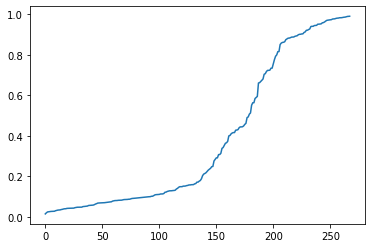

In [7]:
plt.plot(sorted(y_pred))
plt.show()

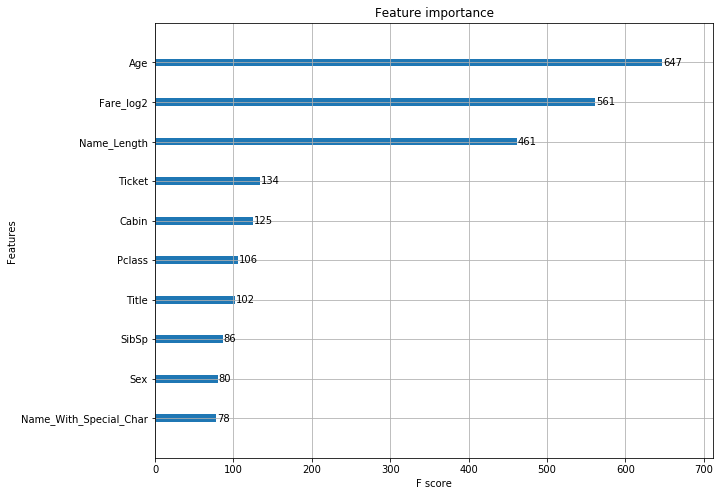

In [62]:
# 請使用 xgboost.plot_importance，並設定max_num_features=10
#!=============your works starts===============!#
xgboost.plot_importance(bst, max_num_features=10)
#!==============your works ends================!#

plt.show()

Thres 上升,  1 會上升, thres = 0.8 把 模型判斷80% 以上為P 

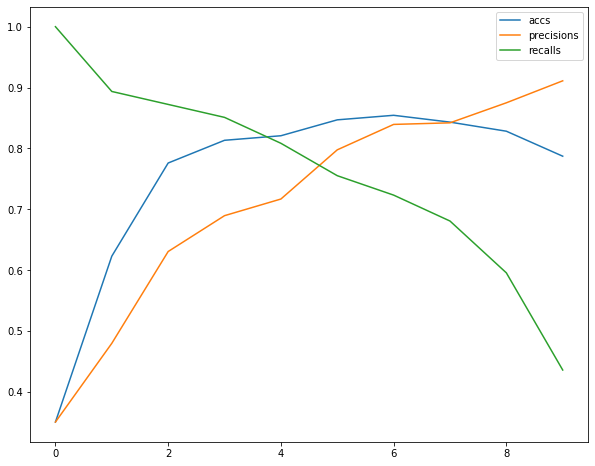

In [70]:
accs = []
precisions = []
recalls = []
Fscores = []
thresholds = np.arange(0, 1, 0.1)
for thres in thresholds:
    y_pred_inner = (y_pred>thres)
#    y_pred_inner = y_pred_inner # 模型預測他會存活
    Y_valid_inner = Y_valid.astype(np.bool) # 實際上他存活
    TP = np.sum((y_pred_inner == True) * (Y_valid_inner == True))
    TN = np.sum((y_pred_inner == False) * (Y_valid_inner == False))
    FP = np.sum((y_pred_inner == True) * (Y_valid_inner == False))
    FN = np.sum((y_pred_inner == False) * (Y_valid_inner == True))
    acc = (TP+TN) / (TP+TN+FP+FN)
    precision = TP / (TP+FP)
    recall = TP / (TP+FN)
    Fscore = 2*precision*recall / (precision + recall)
    accs.append(acc)
    precisions.append(precision)
    recalls.append(recall)
    Fscores.append(Fscore)
    
plt.plot(accs, label='accs')
plt.plot(precisions, label='precisions')
plt.plot(recalls, label='recalls')
# plt.plot(Fscores, label='Fscores')
plt.legend()
plt.show()



# 空氣品質

In [45]:
# dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%Y %H:%M:%S')
# dateparse_1 = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
# EPA_6 = pd.read_csv('air_pollution_data/EPA_OD_201806.csv', parse_dates=['PublishTime'], date_parser=dateparse)
# EPA_7 = pd.read_csv('air_pollution_data/EPA_OD_201807.csv', parse_dates=['PublishTime'], date_parser=dateparse)
# EPA_8 = pd.read_csv('air_pollution_data/EPA_OD_201808.csv', parse_dates=['PublishTime'], date_parser=dateparse)
# EPA_9 = pd.read_csv('air_pollution_data/EPA_OD_201809.csv', parse_dates=['PublishTime'], date_parser=dateparse)
# EPA_10 = pd.read_csv('air_pollution_data/EPA_OD_201810.csv', parse_dates=['PublishTime'], date_parser=dateparse)
# EPA_11 = pd.read_csv('air_pollution_data/EPA_OD_201811.csv', parse_dates=['PublishTime'], date_parser=dateparse)
# EPA_12 = pd.read_csv('air_pollution_data/EPA_OD_201812.csv', parse_dates=['PublishTime'], date_parser=dateparse_1)
# frames = [EPA_6, EPA_7, EPA_8, EPA_9, EPA_10, EPA_11, EPA_12]
# df_AQI = pd.concat(frames)
# df_AQI.to_pickle('air_pollution_data.pkl')
# df_AQI.head()

In [46]:
# df_AQI = pd.read_pickle('air_pollution_data.pkl')
# df_AQI.sort_values(by='PublishTime', inplace=True)
# df_AQI = df_AQI.loc[df_AQI['SiteName'] == '麥寮', ['SiteName', 'AQI', 'PM2.5', 'SO2', 'PublishTime']]
# df_AQI.to_pickle('df_AQI_gl.pkl')

In [47]:
df_AQI = pd.read_pickle('df_AQI_gl.pkl')

In [48]:
window = 7
shift = 1
segments = int((df_AQI.shape[0] - window) // shift) + 1

train = np.zeros((segments-1, 2 * window))
target = np.zeros((segments-1,))
for segment in range(segments -1):
    seg = df_AQI.iloc[segment:segment+window][['SO2', 'PM2.5']]
    target[segment] = df_AQI.iloc[segment+window][['AQI']]
    train[segment] = np.append(seg['SO2'].values, seg['PM2.5'].values)

In [13]:
train = np.where(np.isnan(train), -1, train)
target = np.where(np.isnan(target), int(np.nanmean(target)), target)

In [14]:
train.shape, target.shape

((4721, 14), (4721,))

In [49]:
X_train, X_valid, Y_train, Y_valid = train_test_split(train, target, test_size=0.2, random_state=2019)
X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

((3776, 14), (3776,), (945, 14), (945,))

In [32]:
# Set our parameters for xgboost
params = {}

# 請填入以下參數: 
# 目標函數: 線性回歸
# 評價函數: rmse
# 學習速度: 0.01
# 最大深度: 5
# bst = xgboost.train(params, d_train, 3000, watchlist, early_stopping_rounds=50, verbose_eval=10)
#=============your works starts===============#
params['objective'] = 'reg:linear'
params['eval_metric'] = 'rmse'
params['eta'] = 0.01
params['max_depth'] = 3
d_train = xgboost.DMatrix(X_train, label=Y_train)
d_valid = xgboost.DMatrix(X_valid, label=Y_valid)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgboost.train(params, d_train, 3000, watchlist, early_stopping_rounds=100, verbose_eval=0)
Y_pred = bst.predict(xgboost.DMatrix(X_valid))
#==============your works ends================#


[11:03:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


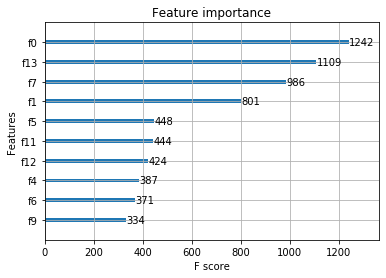

In [33]:
# 請使用 xgboost.plot_importance，並設定max_num_features=10
#!=============your works starts===============!#
xgboost.plot_importance(bst, max_num_features=10)
#!==============your works ends================!#

plt.show()

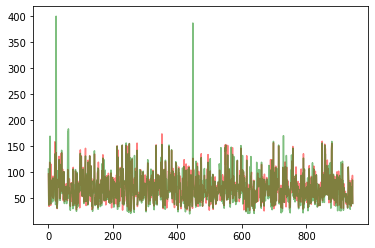

In [34]:
plt.plot(Y_pred, label='Y_pred', alpha=0.5, c='r')
plt.plot(Y_valid, label='Y_valid', alpha=0.5, c='g')
plt.show()

In [35]:
df_result = pd.DataFrame()

# 1. 使用X_valid去評價此模型
# 2. 使用 ['predict', 'truth', 'error'] 三個欄位的DataFrame去使決畫呈現預測結果
#    (1). 請注意與測結果(Y_pred)與真實值(Y_valid)都必須取exp方能反映實際情況
#    (2). error 請使用計算np.abs(predict-truth)/truth計算誤差百分比
# 3. 使用truth欄位排序dataframe rows
#=============your works starts===============#
Y_pred = bst.predict(xgboost.DMatrix(X_valid))
df_result['predict'] = Y_pred
df_result['truth'] = Y_valid
df_result['error'] = np.abs(Y_pred - Y_valid)/ Y_valid
df_result_sort = df_result.sort_values('truth')
#==============your works ends================#

df_result_sort.head()

,predict,truth,error
438,25.840677,20.0,0.292034
619,33.052963,21.0,0.573951
255,25.341028,21.0,0.206716
624,26.800369,21.0,0.276208
638,26.261137,21.0,0.250530


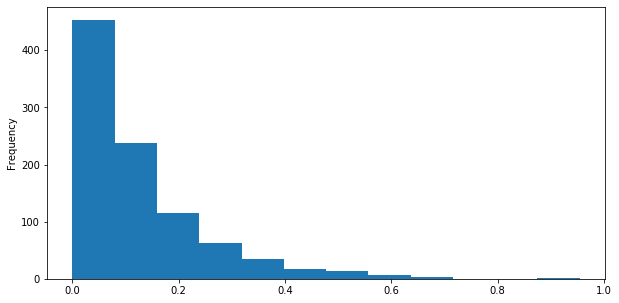

In [53]:
plt.figure(figsize = (10,5))
# 請使用df_result_sort畫出error的分布圖
#!=============your works starts===============!#
df_result_sort['error'].plot(kind='hist', bins=12)
#!==============your works ends================!#

plt.show()

No handles with labels found to put in legend.


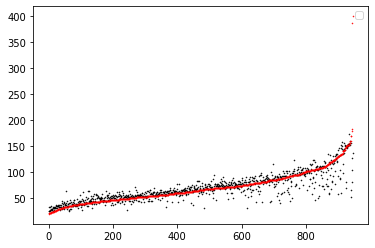

In [38]:
# 請使用plt.scatter，以0~len(df_result)作為x，預測值(黑色)與實際值(紅色)作為y。
#!=============your works starts===============!#
plt.scatter(range(len(df_result_sort)), df_result_sort['predict'], color='black', s=0.3)
plt.scatter(range(len(df_result_sort)), df_result_sort['truth'], color='r', s=0.3)

#!==============your works ends================!#

plt.legend()
plt.show()

# 水稻田

In [83]:
import os
import tarfile
import shutil
import pandas as pd
import numpy as np
import pylab as plt
import cv2
img_dir = os.path.join('farm_data', 'lands_pieces_tif_practice')


In [19]:
class Normalizer():
    def fit(self, X, min_val=None, max_val=None):
        self.min = np.nanmin(X) if min_val == None else min_val
        self.max = np.nanmax(X) if max_val == None else max_val
        
    def transform(self, X):
        return (X - self.min) / (self.max - self.min)

    def fit_transform(self, X, min_val=None, max_val=None):
        self.fit(X, min_val, max_val)
        return self.transform(X)
        
    def reverse_transform(self, Y):
        return (Y * (self.max - self.min)) + self.min


In [2]:
if not os.path.isdir(img_dir):
    tar = tarfile.open(os.path.join('farm_data',  'lands_pieces_tif_practice.tar.gz'))
    names = tar.getnames()
    for name in names:
        tar.extract(name,path=os.path.join('farm_data'))
    tar.close()

In [77]:
# fps = [os.path.join(img_dir, fn) for fn in os.listdir(img_dir)]
# i=0
# for fp in fps[:10]:
#     X = get_nparray(fp)
#     X = X[:, :, [i+3, i+2, i+1]]
#     X[X==0] = 1
#     X = np.log(X)
#     plt.imshow(X)
#     plt.imshow(Normalizer().fit_transform(X, min_val=0, max_val=9.913))
#     plt.show()


In [ ]:
def get_nparray(fp):
    # use np.load to load npy data
    with open(fp, 'rb') as f:
        #=============your works starts===============#
        X =
        #==============your works ends================#
    return X

def pad_img_to_300(X, pad_to_n_cols, pad_to_n_rows):
    rows, cols = X.shape[:2]
    padded_cols = pad_to_n_cols - cols if cols < pad_to_n_cols else 0
    padded_rows = pad_to_n_rows - rows if rows < pad_to_n_rows else 0
    # use np.pad with param('constant', constant_values=0) to pad_to_n_cols, pad_to_n_rows
    #=============your works starts===============#
    X =
    #==============your works ends================#
    return X

In [84]:
# 1. get all fps for  os.listdir(img_dir)
# 2. get all data from get_nparray
# 3. pad_img_to_300
# 4. use cv2 to resize  to (50, 50 ,-1) and flatten it
# 5. flatten X
#=============your works starts===============#
fps =
X =
X =
X =
#==============your works ends================#

X.shape

(2685, 42500)

In [79]:
# 1. read csv  from os.path.join('farm_data', 'df_lands.csv')
# 2. get all idxs from filename
# 3. select CULTURE as Y
#=============your works starts===============#
df_lands =
sel_idxs =
Y =
#==============your works ends================#

Y.shape

(2685,)

In [86]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.3, random_state=2019)
X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

((1879, 42500), (1879,), (806, 42500), (806,))

# 房價資料集

In [20]:
# import urllib.request
# if 'df_realestate_processed.csv' not in os.listdir():
#     url = 'https://s3.amazonaws.com/datasets-jeremy/df_realestate_processed.csv'  
#     urllib.request.urlretrieve(url, 'df_realestate_processed.csv')
    
# # processed
# path = "df_realestate_processed.csv"
# df_realestate_processed = pd.read_csv(path)
# X = df_realestate_processed.drop(["price_per_meter", "total_price"], axis=1)
# Y = df_realestate_processed['total_price']


In [21]:
# X_train = X.iloc[:-1000]
# Y_train = Y.iloc[:-1000]
# Y_train = np.log(Y_train) 

# X_valid = X.iloc[-1000:]
# Y_valid = Y.iloc[-1000:]
# Y_valid = np.log(Y_valid) 

In [22]:
# # Set our parameters for xgboost
# params = {}

# # 請填入以下參數: 
# # 目標函數: 線性回歸
# # 評價函數: rmse
# # 學習速度: 0.01
# # 最大深度: 5
# # bst = xgboost.train(params, d_train, 3000, watchlist, early_stopping_rounds=50, verbose_eval=10)
# #=============your works starts===============#
# params['objective'] =
# params['eval_metric'] =
# params['eta'] =
# params['max_depth'] =
# d_train =
# d_valid =
# watchlist =
# bst =
# Y_pred =
# #==============your works ends================#


In [23]:
#　模型save與load的方式自己看
# bst.save_model("bst_subtotal_log_with_cross.pickle.dat")
# bst = xgboost.Booster({'nthread':1}) #init model
# bst.load_model("bst_subtotal_log_with_cross.pickle.dat") # load data


In [24]:
# # 請使用 xgboost.plot_importance，並設定max_num_features=10
# #!=============your works starts===============!#

# #!==============your works ends================!#

# plt.show()

In [25]:
# df_result = pd.DataFrame()

# # 1. 使用X_valid去評價此模型
# # 2. 使用 ['predict', 'truth', 'error'] 三個欄位的DataFrame去使決畫呈現預測結果
# #    (1). 請注意與測結果(Y_pred)與真實值(Y_valid)都必須取exp方能反映實際情況
# #    (2). error 請使用計算np.abs(predict-truth)/truth計算誤差百分比
# #=============your works starts===============#
# Y_pred =
# df_result['predict'] =
# df_result['truth'] =
# df_result['error'] =
# df_result_sort =
# #==============your works ends================#

# df_result.head()

In [26]:
# # 請使用df_result_sort濾掉error大於1的部分畫出error的分布圖
# #!=============your works starts===============!#

# #!==============your works ends================!#

# plt.show()

In [27]:
# # 請使用plt.scatter，以0~len(df_result)作為x，預測值(黑色)與實際值(紅色)作為y。
# #!=============your works starts===============!#


# #!==============your works ends================!#

# plt.show()